In [37]:
using Trixi
using OrdinaryDiffEq
using Plots

advection_velocity = 1.0
equations = LinearScalarAdvectionEquation1D(advection_velocity)

#initial_condition_sine_wave(x, t, equations) = SVector(1.0 + 0.5 * sin(pi * sum(x - equations.advection_velocity * t)))


dg = DGMulti(polydeg = 3,
             element_type = Tri(),
             approximation_type = SBP(),
             surface_flux = flux_lax_friedrichs,
             volume_integral = VolumeIntegralPureLGLFiniteVolume(flux_lax_friedrichs))

coordinates_min = -1.0 
coordinates_max = 1.0 

mesh = TreeMesh(coordinates_min, coordinates_max,
                initial_refinement_level=4,
                n_cells_max=30_000)

#=mesh = DGMultiMesh(dg,
                   cells_per_dimension=(32), # initial_refinement_level = 5
                   coordinates_min,
                   coordinates_max,
                   periodicity=true)=#

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition_sine_wave, dg,
                                   boundary_conditions=boundary_condition_periodic)
#tspan = (0.0, 0.4)
#ode = semidiscretize(semi, tspan)

#alive_callback = AliveCallback(alive_interval=10)
#analysis_callback = AnalysisCallback(semi, interval=100, uEltype=real(dg))
#callbacks = CallbackSet(analysis_callback, alive_callback);

MethodError: MethodError: no method matching get_nodes(::StartUpDG.RefElemData{2, Tri, SBP{StartUpDG.Kubatko{StartUpDG.LobattoFaceNodes}}, Tuple{Vector{Int64}, Vector{Int64}, Vector{Int64}}, Tuple{Vector{Float64}, Vector{Float64}}, Tuple{Vector{Float64}, Vector{Float64}}, Tuple{Vector{Float64}, Vector{Float64}}, Tuple{Vector{Float64}, Vector{Float64}}, Tuple{Vector{Float64}, Vector{Float64}}, Vector{Int64}, Matrix{Float64}, LinearAlgebra.UniformScaling{Bool}, SparseArrays.SparseMatrixCSC{Float64, Int64}, LinearAlgebra.Diagonal{Float64, Vector{Float64}}, LinearAlgebra.UniformScaling{Bool}, Tuple{Matrix{Float64}, Matrix{Float64}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Matrix{Float64}, Matrix{Float64}, Vector{Float64}, Vector{Float64}})
Closest candidates are:
  get_nodes(!Matched::LobattoLegendreBasis) at ~/.julia/packages/Trixi/enFLf/src/solvers/dgsem/basis_lobatto_legendre.jl:114
  get_nodes(!Matched::SummationByPartsOperators.AbstractDerivativeOperator) at ~/.julia/packages/Trixi/enFLf/src/solvers/fdsbp_tree/fdsbp.jl:38

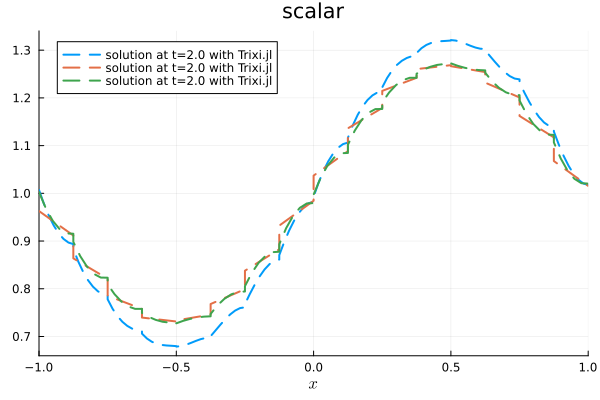

In [5]:
using Trixi, OrdinaryDiffEq, Plots

# equation with a advection_velocity of `1`.
advection_velocity = 1.0
equations = LinearScalarAdvectionEquation1D(advection_velocity)

# create DG solver with flux lax friedrichs and LGL basis
#solver = DGSEM(polydeg=3, surface_flux=flux_lax_friedrichs)

solver = DGSEM(polydeg=2, surface_flux=flux_lax_friedrichs,
                  volume_integral=VolumeIntegralPureLGLFiniteVolume(flux_lax_friedrichs))

#=solver = DGMulti(polydeg = 3,
             element_type = Quad(),
             approximation_type = SBP(),
             surface_flux = flux_lax_friedrichs,
             volume_integral = VolumeIntegralFluxDifferencing(flux_ranocha))=#

#=solver = DGMulti(polydeg = 3,
             element_type = Line(),
             approximation_type = GaussSBP(),
             surface_integral = SurfaceIntegralWeakForm(flux_lax_friedrichs),
             volume_integral = VolumeIntegralWeakForm)=#

# distretize domain with `TreeMesh`
coordinates_min = -1.0 # minimum coordinate
coordinates_max = 1.0 # maximum coordinate
mesh = TreeMesh(coordinates_min, coordinates_max,
                initial_refinement_level=4, # number of elements = 2^4
                n_cells_max=30_000)
#=mesh = DGMultiMesh(solver,
                   cells_per_dimension=(8,),
                   coordinates_min=(-1.0,),
                   coordinates_max=(1.0,),
                   periodicity=true)=#

# create initial condition and semidiscretization
initial_condition_sine_wave(x, t, equations) = SVector(1.0 + 0.5 * sin(pi * sum(x - equations.advection_velocity * t)))

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition_sine_wave, solver)

# solve
tspan = (0.0, 2.0)
ode_trixi  = semidiscretize(semi, tspan)
sol_trixi  = solve(ode_trixi, RDPK3SpFSAL49(), abstol=1.0e-6, reltol=1.0e-6, save_everystep=false);

plot!(sol_trixi, label="solution at t=$(tspan[2]) with Trixi.jl", legend=:topleft, linestyle=:dash, lw=2)

In [62]:

using OrdinaryDiffEq
using Trixi

###############################################################################
#  setup the equations

advection_velocity = 1.0
equations = LinearScalarAdvectionEquation1D(advection_velocity)

###############################################################################
#  setup the GSBP DG discretization that uses the Gauss operators from Chan et al.

surface_flux = FluxLaxFriedrichs()
dg = DGMulti(polydeg = 3,
             element_type = Line(),
             approximation_type = GaussSBP(),
             #surface_integral = SurfaceIntegralWeakForm(surface_flux),
             volume_integral = VolumeIntegralPureLGLFiniteVolume(surface_flux))

###############################################################################
#  setup the 1D mesh

mesh = DGMultiMesh(dg,
                   cells_per_dimension=(8,),
                   coordinates_min=(-1.0,),
                   coordinates_max=(1.0,),
                   periodicity=true)

###############################################################################
#  setup the test problem (no source term needed for linear advection)

#initial_condition = initial_condition_convergence_test
initial_condition_sine_wave(x, t, equations) = SVector(1.0 + 0.5 * sin(pi * sum(x - equations.advection_velocity * t)))
###############################################################################
#  setup the semidiscretization and ODE problem

semi = SemidiscretizationHyperbolic(mesh,
                                    equations,
                                    #initial_condition,
                                    initial_condition_sine_wave,
                                    dg)

tspan = (0.0, 2.0)
ode = semidiscretize(semi, tspan)

###############################################################################
#  setup the callbacks

# prints a summary of the simulation setup and resets the timers
summary_callback = SummaryCallback()

# analyse the solution in regular intervals and prints the results
analysis_callback = AnalysisCallback(semi, interval=100, uEltype=real(dg))

# handles the re-calculcation of the maximum Δt after each time step
stepsize_callback = StepsizeCallback(cfl=0.75)

# collect all callbacks such that they can be passed to the ODE solver
callbacks = CallbackSet(summary_callback, analysis_callback, stepsize_callback)

###############################################################################
# run the simulation

sol  = solve(ode, RDPK3SpFSAL49(), abstol=1.0e-6, reltol=1.0e-6, save_everystep=false);



# Print the timer summary
#summary_callback()

plot!(sol)

MethodError: MethodError: no method matching create_cache(::DGMultiMesh{1, Trixi.Affine, StartUpDG.MeshData{1, StartUpDG.VertexMappedMesh{Line, Tuple{Vector{Float64}}, Matrix{Int64}}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Int64}, Matrix{Float64}, StaticArraysCore.SMatrix{1, 1, Matrix{Float64}, 1}, Matrix{Float64}, Matrix{Int64}, Matrix{Int64}, Vector{Matrix{Float64}}}, Dict{Symbol, Vector{Int64}}}, ::LinearScalarAdvectionEquation1D{Float64}, ::DGMulti{1, Line, GaussSBP, SurfaceIntegralWeakForm{typeof(flux_central)}, VolumeIntegralPureLGLFiniteVolume{FluxLaxFriedrichs{typeof(max_abs_speed_naive)}}, Nothing, StartUpDG.RefElemData{1, Line, GaussSBP, Tuple{Int64, Int64}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Tuple{Vector{Float64}}, Vector{Int64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Tuple{Matrix{Float64}}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Vector{Float64}, Vector{Float64}}}, ::Type{Float64}, ::Type{Float64})
Closest candidates are:
  create_cache(::DGMultiMesh, ::Any, !Matched::DGMulti{NDIMS, var"#s3375", var"#s3376", var"#s3726", var"#s3725", Mortar, <:StartUpDG.RefElemData{NDIMS, var"#s3375", var"#s3376"}} where {var"#s3376"<:GaussSBP, var"#s3375"<:Union{Hex, Quad}, NDIMS, var"#s3726"<:SurfaceIntegralWeakForm, var"#s3725"<:VolumeIntegralFluxDifferencing, Mortar}, ::Any, ::Any) at ~/.julia/packages/Trixi/enFLf/src/solvers/dgmulti/flux_differencing_gauss_sbp.jl:379
  create_cache(::DGMultiMesh, ::Any, !Matched::DGMulti{NDIMS, ElemType, ApproxType, SurfaceIntegral, VolumeIntegral, Mortar, <:StartUpDG.RefElemData{NDIMS, ElemType, ApproxType}} where {NDIMS, ElemType, ApproxType<:SummationByPartsOperators.AbstractPeriodicDerivativeOperator, SurfaceIntegral<:SurfaceIntegralWeakForm, VolumeIntegral<:VolumeIntegralFluxDifferencing, Mortar}, ::Any, ::Any) at ~/.julia/packages/Trixi/enFLf/src/solvers/dgmulti/sbp.jl:466
  create_cache(::DGMultiMesh, ::Any, !Matched::DGMulti{NDIMS, ElemType, ApproxType, var"#s3726", var"#s3725", Mortar, <:StartUpDG.RefElemData{NDIMS, ElemType, ApproxType}} where {ElemType, NDIMS, ApproxType<:Union{SBP, SummationByPartsOperators.AbstractDerivativeOperator}, var"#s3726"<:SurfaceIntegralWeakForm, var"#s3725"<:VolumeIntegralFluxDifferencing, Mortar}, ::Any, ::Any) at ~/.julia/packages/Trixi/enFLf/src/solvers/dgmulti/flux_differencing.jl:277
  ...